In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import sys
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.master("local").appName("Irish Marine Institute - Data Prep").getOrCreate()

In [3]:
df = spark.read.csv("dataset/IrishNationalTideGaugeNetwork.csv", header=True, inferSchema=True)
df.show(vertical=True)

-RECORD 0------------------------------------
 time                 | UTC                  
 altitude             | m                    
 latitude             | degrees_north        
 longitude            | degrees_east         
 station_id           | null                 
 datasourceid         | null                 
 Water_Level_LAT      | metres               
 Water_Level_OD_Malin | metres               
 QC_Flag              | null                 
-RECORD 1------------------------------------
 time                 | 2006-10-26T13:00:00Z 
 altitude             | 0.0                  
 latitude             | 53.585               
 longitude            | -6.1081              
 station_id           | Skerries Harbour     
 datasourceid         | 11                   
 Water_Level_LAT      | 4.679                
 Water_Level_OD_Malin | 1.82                 
 QC_Flag              | 1                    
-RECORD 2------------------------------------
 time                 | 2006-10-26

In [4]:
df.printSchema()

root
 |-- time: string (nullable = true)
 |-- altitude: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- station_id: string (nullable = true)
 |-- datasourceid: integer (nullable = true)
 |-- Water_Level_LAT: string (nullable = true)
 |-- Water_Level_OD_Malin: string (nullable = true)
 |-- QC_Flag: integer (nullable = true)



In [5]:
from pyspark.sql.functions import from_utc_timestamp
from pyspark.sql.functions import col
from pyspark.sql.functions import year, to_date
from pyspark.sql.functions import dayofmonth, month, year,hour, minute

# Convert the string column to a datetime column
df = df.withColumn("Water_Level_LAT", col("Water_Level_LAT").cast("float"))
df = df.withColumn("Water_Level_OD_Malin", col("Water_Level_OD_Malin").cast("float"))
df = df.withColumn("latitude", col("latitude").cast("float"))
df = df.withColumn("longitude", col("longitude").cast("float"))

df = df.withColumn("minute", minute(to_date(df.time)))
df = df.withColumn("hour", hour(to_date(df.time)))
df = df.withColumn("day", dayofmonth(to_date(df.time)))
df = df.withColumn("month", month(to_date(df.time)))
df = df.withColumn("year", year(to_date(df.time)))


df = df.withColumn("day", dayofmonth(to_date(df.time)))
df = df.withColumn("month", month(to_date(df.time)))
df = df.withColumn("year", year(to_date(df.time)))

df = df.filter((df.latitude == '53.585') & (df.longitude == '-6.1081'))
df = df.filter(df.Water_Level_OD_Malin < '5')
df = df.filter(df.Water_Level_OD_Malin > '-5')
df = df.na.drop()
df.show()
df.printSchema()




+--------------------+--------+--------+---------+----------------+------------+---------------+--------------------+-------+------+----+---+-----+----+
|                time|altitude|latitude|longitude|      station_id|datasourceid|Water_Level_LAT|Water_Level_OD_Malin|QC_Flag|minute|hour|day|month|year|
+--------------------+--------+--------+---------+----------------+------------+---------------+--------------------+-------+------+----+---+-----+----+
|2006-10-26T13:00:00Z|     0.0|  53.585|  -6.1081|Skerries Harbour|          11|          4.679|                1.82|      1|     0|   0| 26|   10|2006|
|2006-10-26T14:00:00Z|     0.0|  53.585|  -6.1081|Skerries Harbour|          11|          4.939|                2.08|      1|     0|   0| 26|   10|2006|
|2006-10-26T14:06:00Z|     0.0|  53.585|  -6.1081|Skerries Harbour|          11|          4.969|                2.11|      1|     0|   0| 26|   10|2006|
|2006-10-26T14:12:00Z|     0.0|  53.585|  -6.1081|Skerries Harbour|          11|  

In [6]:
df.dtypes

[('time', 'string'),
 ('altitude', 'string'),
 ('latitude', 'float'),
 ('longitude', 'float'),
 ('station_id', 'string'),
 ('datasourceid', 'int'),
 ('Water_Level_LAT', 'float'),
 ('Water_Level_OD_Malin', 'float'),
 ('QC_Flag', 'int'),
 ('minute', 'int'),
 ('hour', 'int'),
 ('day', 'int'),
 ('month', 'int'),
 ('year', 'int')]

In [7]:
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCol="time" ,outputCol="indexedTime")
indexed = indexer.fit(df).transform(df)
indexed.show(vertical=True)

-RECORD 0------------------------------------
 time                 | 2006-10-26T13:00:00Z 
 altitude             | 0.0                  
 latitude             | 53.585               
 longitude            | -6.1081              
 station_id           | Skerries Harbour     
 datasourceid         | 11                   
 Water_Level_LAT      | 4.679                
 Water_Level_OD_Malin | 1.82                 
 QC_Flag              | 1                    
 minute               | 0                    
 hour                 | 0                    
 day                  | 26                   
 month                | 10                   
 year                 | 2006                 
 indexedTime          | 0.0                  
-RECORD 1------------------------------------
 time                 | 2006-10-26T14:00:00Z 
 altitude             | 0.0                  
 latitude             | 53.585               
 longitude            | -6.1081              
 station_id           | Skerries H

In [8]:
fd_1 = indexed.selectExpr("cast(time as string)dateTime",
                          "cast(minute as int)minute",
                          "cast(hour as int)hour",
                          "cast(day as int)day",
                          "cast(month as int)month",
                          "cast(year as int)year",
                          "cast(Water_Level_OD_Malin as float) label")

tran_fd_1 = fd_1.filter((fd_1.year == 2020))
test_fd_1 = fd_1.filter((fd_1.year == 2020))

In [9]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = ['minute','hour','day','month'],
                                  handleInvalid="skip",
                                  outputCol ='features')

In [10]:
vhouse_df_tran = vectorAssembler.transform(tran_fd_1)
trainingData = vhouse_df_tran.select("features", "label")
trainingData.show()

vhouse_df_test = vectorAssembler.transform(test_fd_1)
testData = vhouse_df_test.select("features", "label")
testData.show()

+------------------+------+
|          features| label|
+------------------+------+
|[0.0,0.0,3.0,11.0]| 0.238|
|[0.0,0.0,3.0,11.0]| 0.163|
|[0.0,0.0,3.0,11.0]| 0.106|
|[0.0,0.0,3.0,11.0]| 0.038|
|[0.0,0.0,3.0,11.0]|-0.058|
|[0.0,0.0,3.0,11.0]|-0.139|
|[0.0,0.0,3.0,11.0]|-0.222|
|[0.0,0.0,3.0,11.0]|-0.298|
|[0.0,0.0,3.0,11.0]|-0.382|
|[0.0,0.0,3.0,11.0]| -0.46|
|[0.0,0.0,3.0,11.0]|-0.533|
|[0.0,0.0,3.0,11.0]|-0.618|
|[0.0,0.0,3.0,11.0]|-0.701|
|[0.0,0.0,3.0,11.0]|-0.783|
|[0.0,0.0,3.0,11.0]|-0.854|
|[0.0,0.0,3.0,11.0]|-0.923|
|[0.0,0.0,3.0,11.0]|-0.973|
|[0.0,0.0,3.0,11.0]|-1.063|
|[0.0,0.0,3.0,11.0]| -1.11|
|[0.0,0.0,3.0,11.0]|-1.166|
+------------------+------+
only showing top 20 rows

+------------------+------+
|          features| label|
+------------------+------+
|[0.0,0.0,3.0,11.0]| 0.238|
|[0.0,0.0,3.0,11.0]| 0.163|
|[0.0,0.0,3.0,11.0]| 0.106|
|[0.0,0.0,3.0,11.0]| 0.038|
|[0.0,0.0,3.0,11.0]|-0.058|
|[0.0,0.0,3.0,11.0]|-0.139|
|[0.0,0.0,3.0,11.0]|-0.222|
|[0.0,0.0,3.0,11.0]|-0

In [11]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
lr = LinearRegression(featuresCol="features", labelCol="label")
model = lr.fit(trainingData)
# Make predictions.
predictions = model.transform(testData)
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("rmse = %g" % rmse)
predictions.show()

rmse = 1.20226
+------------------+------+-------------------+
|          features| label|         prediction|
+------------------+------+-------------------+
|[0.0,0.0,3.0,11.0]| 0.238|0.07587907245995279|
|[0.0,0.0,3.0,11.0]| 0.163|0.07587907245995279|
|[0.0,0.0,3.0,11.0]| 0.106|0.07587907245995279|
|[0.0,0.0,3.0,11.0]| 0.038|0.07587907245995279|
|[0.0,0.0,3.0,11.0]|-0.058|0.07587907245995279|
|[0.0,0.0,3.0,11.0]|-0.139|0.07587907245995279|
|[0.0,0.0,3.0,11.0]|-0.222|0.07587907245995279|
|[0.0,0.0,3.0,11.0]|-0.298|0.07587907245995279|
|[0.0,0.0,3.0,11.0]|-0.382|0.07587907245995279|
|[0.0,0.0,3.0,11.0]| -0.46|0.07587907245995279|
|[0.0,0.0,3.0,11.0]|-0.533|0.07587907245995279|
|[0.0,0.0,3.0,11.0]|-0.618|0.07587907245995279|
|[0.0,0.0,3.0,11.0]|-0.701|0.07587907245995279|
|[0.0,0.0,3.0,11.0]|-0.783|0.07587907245995279|
|[0.0,0.0,3.0,11.0]|-0.854|0.07587907245995279|
|[0.0,0.0,3.0,11.0]|-0.923|0.07587907245995279|
|[0.0,0.0,3.0,11.0]|-0.973|0.07587907245995279|
|[0.0,0.0,3.0,11.0]|-1.06

In [12]:
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.functions import lit
df2 = spark.sql("SELECT sequence(to_date('2023-01-01 14:00:00'), to_date('2023-12-31 14:00:00'), interval 1 day) as time").withColumn('time', F.explode('time'))

df2 = df2.withColumn("day", dayofmonth(df2.time))
df2 = df2.withColumn("month", month(df2.time))
df2 = df2.withColumn("year", year(df2.time))
df2 = df2.withColumn("hour", lit(12))
df2 = df2.withColumn("minute", lit(0))
df2 = df2.withColumn("timeString", col("time").cast("string"))
df2.show()

+----------+---+-----+----+----+------+----------+
|      time|day|month|year|hour|minute|timeString|
+----------+---+-----+----+----+------+----------+
|2023-01-01|  1|    1|2023|  12|     0|2023-01-01|
|2023-01-02|  2|    1|2023|  12|     0|2023-01-02|
|2023-01-03|  3|    1|2023|  12|     0|2023-01-03|
|2023-01-04|  4|    1|2023|  12|     0|2023-01-04|
|2023-01-05|  5|    1|2023|  12|     0|2023-01-05|
|2023-01-06|  6|    1|2023|  12|     0|2023-01-06|
|2023-01-07|  7|    1|2023|  12|     0|2023-01-07|
|2023-01-08|  8|    1|2023|  12|     0|2023-01-08|
|2023-01-09|  9|    1|2023|  12|     0|2023-01-09|
|2023-01-10| 10|    1|2023|  12|     0|2023-01-10|
|2023-01-11| 11|    1|2023|  12|     0|2023-01-11|
|2023-01-12| 12|    1|2023|  12|     0|2023-01-12|
|2023-01-13| 13|    1|2023|  12|     0|2023-01-13|
|2023-01-14| 14|    1|2023|  12|     0|2023-01-14|
|2023-01-15| 15|    1|2023|  12|     0|2023-01-15|
|2023-01-16| 16|    1|2023|  12|     0|2023-01-16|
|2023-01-17| 17|    1|2023|  12

In [13]:
indexer = StringIndexer(inputCol="timeString" ,outputCol="indexedTime")
indexed_predict = indexer.fit(df2).transform(df2)
indexed_predict.show(vertical=True)


-RECORD 0-----------------
 time        | 2023-01-01 
 day         | 1          
 month       | 1          
 year        | 2023       
 hour        | 12         
 minute      | 0          
 timeString  | 2023-01-01 
 indexedTime | 0.0        
-RECORD 1-----------------
 time        | 2023-01-02 
 day         | 2          
 month       | 1          
 year        | 2023       
 hour        | 12         
 minute      | 0          
 timeString  | 2023-01-02 
 indexedTime | 1.0        
-RECORD 2-----------------
 time        | 2023-01-03 
 day         | 3          
 month       | 1          
 year        | 2023       
 hour        | 12         
 minute      | 0          
 timeString  | 2023-01-03 
 indexedTime | 2.0        
-RECORD 3-----------------
 time        | 2023-01-04 
 day         | 4          
 month       | 1          
 year        | 2023       
 hour        | 12         
 minute      | 0          
 timeString  | 2023-01-04 
 indexedTime | 3.0        
-RECORD 4-----------------
 

In [14]:
fd_2 = indexed_predict.selectExpr("cast(time as string)dateTime",
                          "cast(minute as int)minute",
                          "cast(hour as int)hour",
                          "cast(day as int)day",
                          "cast(month as int)month")

vhouse_df2 = vectorAssembler.transform(fd_2)
predictSet = vhouse_df2.select("features","dateTime")
predictSet.show(truncate=False)

+-------------------+----------+
|features           |dateTime  |
+-------------------+----------+
|[0.0,12.0,1.0,1.0] |2023-01-01|
|[0.0,12.0,2.0,1.0] |2023-01-02|
|[0.0,12.0,3.0,1.0] |2023-01-03|
|[0.0,12.0,4.0,1.0] |2023-01-04|
|[0.0,12.0,5.0,1.0] |2023-01-05|
|[0.0,12.0,6.0,1.0] |2023-01-06|
|[0.0,12.0,7.0,1.0] |2023-01-07|
|[0.0,12.0,8.0,1.0] |2023-01-08|
|[0.0,12.0,9.0,1.0] |2023-01-09|
|[0.0,12.0,10.0,1.0]|2023-01-10|
|[0.0,12.0,11.0,1.0]|2023-01-11|
|[0.0,12.0,12.0,1.0]|2023-01-12|
|[0.0,12.0,13.0,1.0]|2023-01-13|
|[0.0,12.0,14.0,1.0]|2023-01-14|
|[0.0,12.0,15.0,1.0]|2023-01-15|
|[0.0,12.0,16.0,1.0]|2023-01-16|
|[0.0,12.0,17.0,1.0]|2023-01-17|
|[0.0,12.0,18.0,1.0]|2023-01-18|
|[0.0,12.0,19.0,1.0]|2023-01-19|
|[0.0,12.0,20.0,1.0]|2023-01-20|
+-------------------+----------+
only showing top 20 rows



In [15]:
result = model.transform(predictSet)
result.show(truncate=False)

+-------------------+----------+--------------------+
|features           |dateTime  |prediction          |
+-------------------+----------+--------------------+
|[0.0,12.0,1.0,1.0] |2023-01-01|-0.13357934089729365|
|[0.0,12.0,2.0,1.0] |2023-01-02|-0.1353978962900404 |
|[0.0,12.0,3.0,1.0] |2023-01-03|-0.13721645168278712|
|[0.0,12.0,4.0,1.0] |2023-01-04|-0.13903500707553387|
|[0.0,12.0,5.0,1.0] |2023-01-05|-0.14085356246828062|
|[0.0,12.0,6.0,1.0] |2023-01-06|-0.14267211786102735|
|[0.0,12.0,7.0,1.0] |2023-01-07|-0.1444906732537741 |
|[0.0,12.0,8.0,1.0] |2023-01-08|-0.14630922864652085|
|[0.0,12.0,9.0,1.0] |2023-01-09|-0.14812778403926757|
|[0.0,12.0,10.0,1.0]|2023-01-10|-0.14994633943201433|
|[0.0,12.0,11.0,1.0]|2023-01-11|-0.15176489482476105|
|[0.0,12.0,12.0,1.0]|2023-01-12|-0.1535834502175078 |
|[0.0,12.0,13.0,1.0]|2023-01-13|-0.15540200561025455|
|[0.0,12.0,14.0,1.0]|2023-01-14|-0.15722056100300127|
|[0.0,12.0,15.0,1.0]|2023-01-15|-0.15903911639574803|
|[0.0,12.0,16.0,1.0]|2023-01

Text(0.5, 0, 'Date-Time')

Text(0, 0.5, 'Value')

Text(0.5, 1.0, 'Graph of Value over Time')

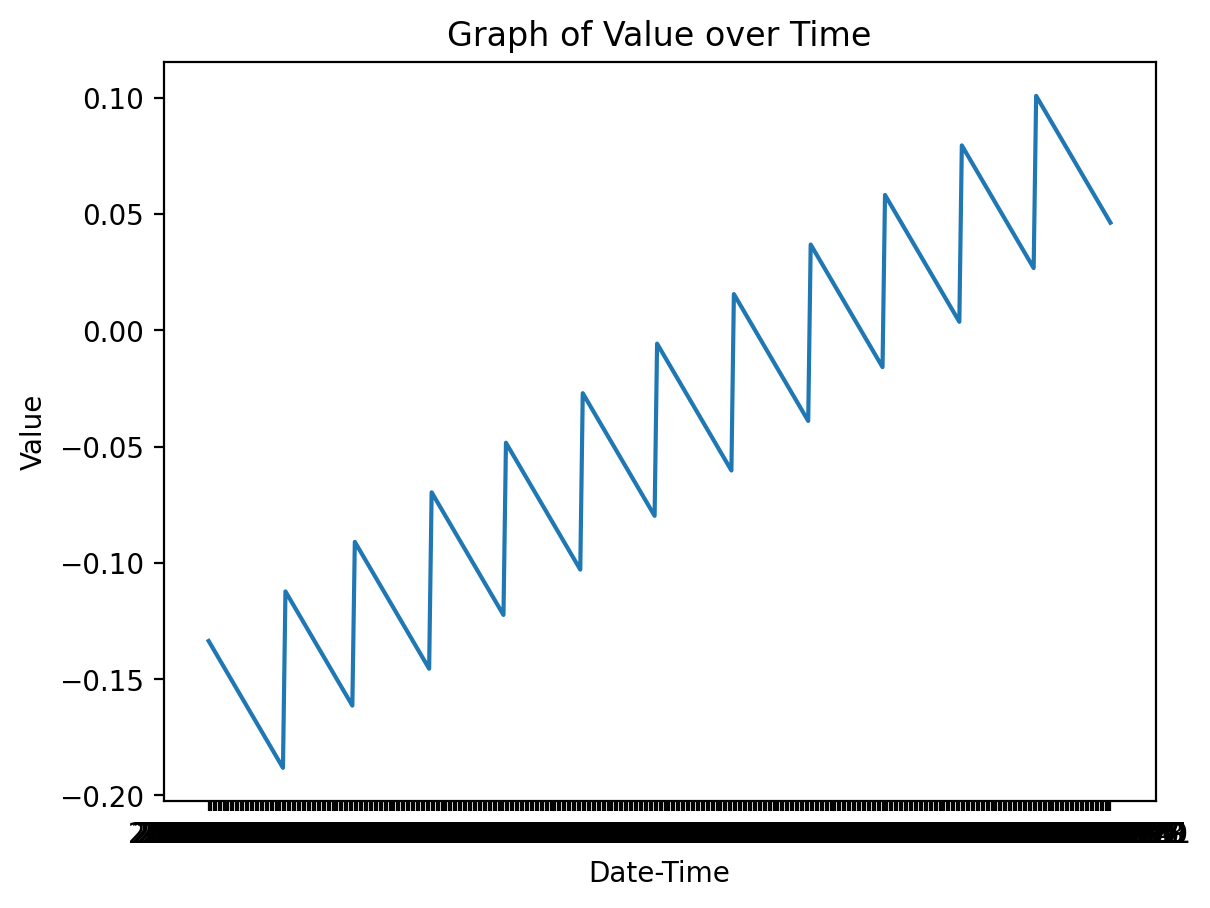

In [16]:
import matplotlib.pyplot as plt

dates = [row[0] for row in result.select("dateTime").collect()]
values = [row[0] for row in result.select("prediction").collect()]

# Plot the graph
plt.plot(dates, values)
plt.xlabel("Date-Time")
plt.ylabel("Value")
plt.title("Graph of Value over Time")
plt.show()
